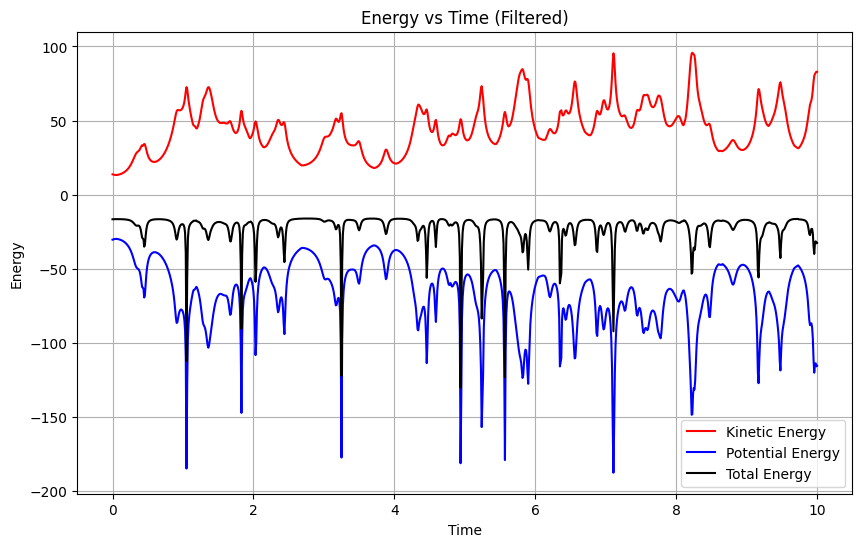

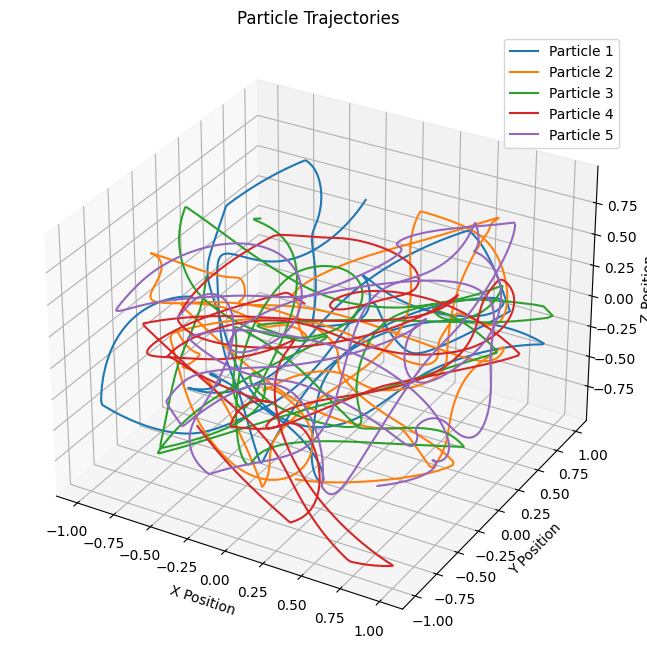

In [1]:
import matplotlib
%matplotlib inline
import utils as ut
import importlib
import GNN_utils
import torch
from datetime import datetime
import os
from torch.utils.tensorboard import SummaryWriter
import loggers as loggers
import torch.nn as torch_nn
import GNN_models

importlib.reload(ut)

seed_value = 42

torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)

N = 5  # Number of particles
tEnd = 10.0  # time at which simulation ends
dt = 0.01  # timestep
softening = 0.15  # softening length
G = 1.0  # Newton's Gravitational Constant
boxSize = 1.0
mass_coef = 10.0
dims = 3

combined_data = ut.simulate_gravitational_system(seed_value, N, tEnd, dt, softening, G, boxSize, mass_coef, dims=dims,
                                                 init_boxsize=boxSize)

LOG_WANDB = False
t_delta = 10  # how many steps ahead to predict
L_MAX = 1
batch_size = 32
MAX_RADIUS = (boxSize ** 2 + boxSize ** 2 + boxSize ** 2) ** 0.5
NUMBER_OF_BASIS = 10
lr = 1e-2
#lr = 0.005
weight_decay = 0.05
scheduler_gamma = 1
#scheduler_gamma = 0.5

hparams = {
    'N': N,  # Number of particles
    'tEnd': tEnd,  # Time at which simulation ends
    'dt': dt,  # Timestep
    'G': G,  # Newton's Gravitational Constant
    'boxSize': boxSize,  # Size of the simulation box
    'mass_coef': mass_coef,  # Mass coefficient
    'lr': lr
}

model_dict = {
    "irreps_in": "1x1o",
    "irreps_out": "2x1o",
    "layers": 3,
    "mul": 32,
    "lmax": L_MAX,  # Assuming L_MAX is defined elsewhere
    "max_radius": MAX_RADIUS,  # Assuming MAX_RADIUS is defined elsewhere
    "num_neighbors": N - 1,  # Assuming N is defined elsewhere
    "reduce_output": False,
    "number_of_basis": 10,
    "radial_layers": 2,
    "radial_neurons": 200,
    "num_nodes": 1.,
    "fully_connected": True
}

hparams.update(model_dict)

#experiment
current_time = datetime.now().strftime('%Y-%m-%d %H-%M')
experiment_name = "e3nn_nbody_EGCN"
run_name = current_time + "_" + "_".join(str(value) for value in hparams.values())
experiment_folder = os.path.join(experiment_name, run_name)
writer = SummaryWriter(experiment_folder)

loggers_list = [loggers.TensorBoardLogger(writer)]


combined_data shape: (999, 5, 6)
inputs_np shape: (989, 5, 6)
targets_np shape: (989, 5, 6)


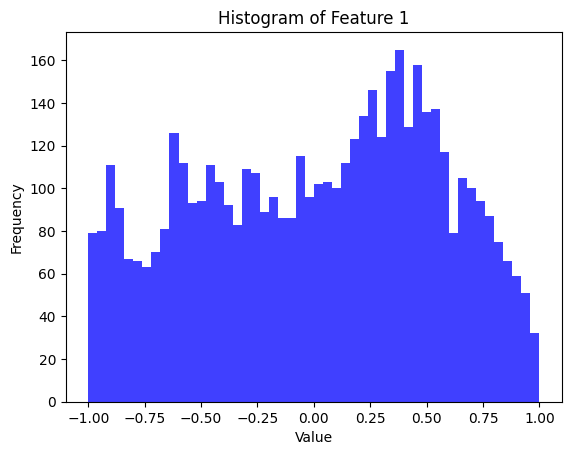

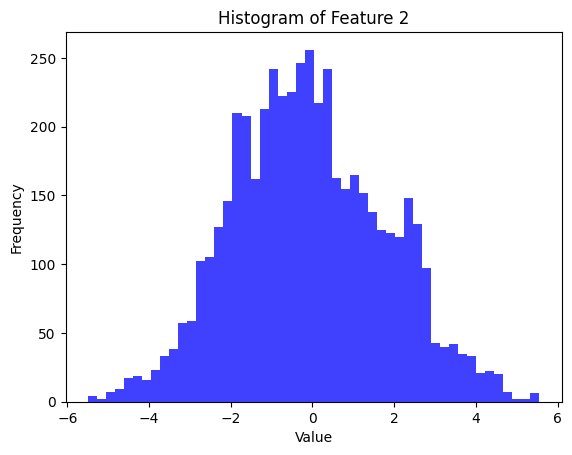

Normalized:


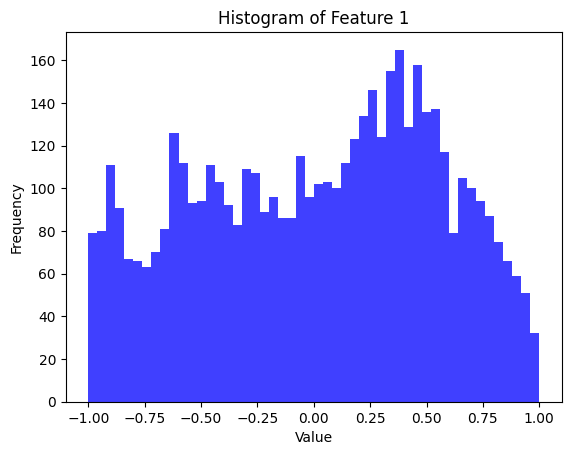

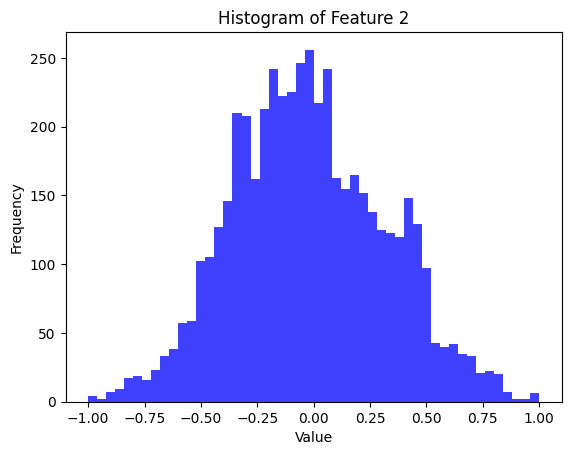

In [2]:
inputs_np, targets_np = ut.process_data(combined_data, dims=dims, t_delta=t_delta)

# Dataloader

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
data_loader = GNN_utils.create_graph_dataset(inputs_np, targets_np, batch_size=batch_size, dims=dims,
                                             max_radius=MAX_RADIUS,
                                             num_basis=NUMBER_OF_BASIS)

# GCN with fairy dust and all the fancy stuff..

In [4]:
model = GNN_models.EGCN(**model_dict)

/home/mightycarrot/anaconda3/envs/n_body_approx/lib/python3.8/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/mightycarrot/anaconda3/envs/n_body_approx/lib/python3.8/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/mightycarrot/anaconda3/envs/n_body_approx/lib/python3.8/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/mightycarrot/anaconda3/envs/n_body_approx/lib/python3.8/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/home/mightycarrot/anaconda3/envs/n_body_approx/lib/python3.8/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotatio

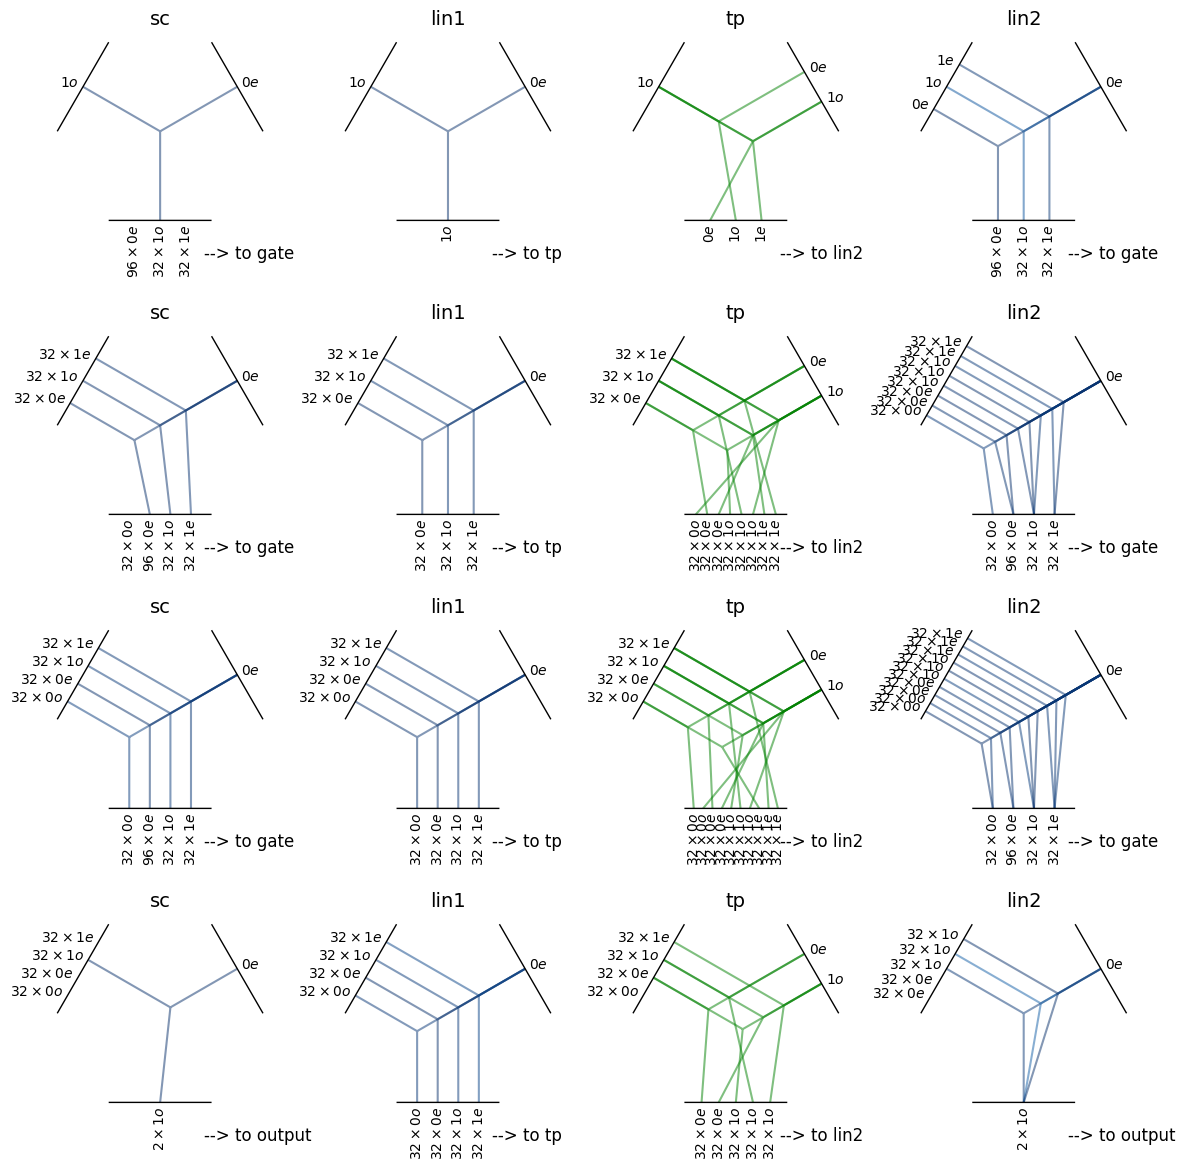

In [5]:
GNN_utils.visualize_layers(model)

In [6]:
model.layers

ModuleList(
  (0): Compose(
    (first): Convolution(
      (sc): FullyConnectedTensorProduct(1x1o x 1x0e -> 96x0e+32x1o+32x1e | 32 paths | 32 weights)
      (lin1): FullyConnectedTensorProduct(1x1o x 1x0e -> 1x1o | 1 paths | 1 weights)
      (fc): FullyConnectedNet[10, 200, 200, 3]
      (tp): TensorProduct(1x1o x 1x0e+1x1o -> 1x0e+1x1o+1x1e | 3 paths | 3 weights)
      (lin2): FullyConnectedTensorProduct(1x0e+1x1o+1x1e x 1x0e -> 96x0e+32x1o+32x1e | 160 paths | 160 weights)
      (alpha): FullyConnectedTensorProduct(1x0e+1x1o+1x1e x 1x0e -> 1x0e | 1 paths | 1 weights)
    )
    (second): Gate (96x0e+32x1o+32x1e -> 32x0e+32x1o+32x1e)
  )
  (1): Compose(
    (first): Convolution(
      (sc): FullyConnectedTensorProduct(32x0e+32x1o+32x1e x 1x0e -> 32x0o+96x0e+32x1o+32x1e | 5120 paths | 5120 weights)
      (lin1): FullyConnectedTensorProduct(32x0e+32x1o+32x1e x 1x0e -> 32x0e+32x1o+32x1e | 3072 paths | 3072 weights)
      (fc): FullyConnectedNet[10, 200, 200, 256]
      (tp): TensorProduct

# EQUIVARIANCE TEST

In [7]:
import importlib

importlib.reload(GNN_utils)
GNN_utils.equivariance_test(model, data_loader)

True
tensor(0.1483, grad_fn=<MeanBackward0>)
tensor(2.6055e-07, grad_fn=<MeanBackward0>)


# Training

In [8]:
import importlib

importlib.reload(GNN_utils)

criterion = torch_nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150 ,gamma=0.1)
last_epoch = 0
num_epochs = 1000
last_epoch, loss = GNN_utils.train_model(model, optimizer, criterion, data_loader, num_epochs, old_epoch=last_epoch,
                             loggers=loggers_list,
                             dims=dims,
                             scheduler=scheduler,
                            device=device)

'Epoch [384/1000], lr: 0.0001, avg_both: 0.00463, avg_pos:  0.00293, avg_vel:  0.00634, perc_pos:  3.24131%, perc_vel:  5.52269%'

Epochs:  38%|███▊      | 383/999 [09:28<15:13,  1.48s/it]

Saving model at the end of training
